In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
data_columns = ["Make", "Model", "Year", "Engine HP", "Engine Cylinders", "Transmission Type", "Vehicle Style",
                "highway MPG", "city mpg", "MSRP"]
cars_info = pd.read_csv(r'C:\Users\Виталий\PycharmProjects\home_work_1\data.csv', usecols=data_columns)
cars_info.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


## data preparation

In [3]:
cars_info.columns = cars_info.columns.str.replace(' ', '_').str.lower()
cars_info = cars_info.fillna(0)
cars_info = cars_info.rename(columns = {"msrp": "price"})
cars_info_copy = cars_info.copy()
mean = cars_info_copy['price'].mean()
cars_info_copy['above_average'] = np.where(cars_info_copy['price']>=mean,1,0)
cars_info_copy = cars_info_copy.drop('price', axis=1)
cars_info_copy.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [4]:
cars_info_copy.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
above_average        0
dtype: int64

## Split dataset

In [5]:
train_val_ds, test_ds = train_test_split(cars_info_copy, test_size=0.2, random_state=42)
train_ds, val_ds = train_test_split(train_val_ds, test_size=0.25, random_state=42)

train_ds = train_ds.reset_index(drop=True)
val_ds = val_ds.reset_index(drop=True)
test_ds = test_ds.reset_index(drop=True)

y_train = train_ds.above_average.values
y_val = val_ds.above_average.values
y_test = test_ds.above_average.values

del train_ds['above_average']
del val_ds['above_average']
del test_ds['above_average']

## Question 1

In [6]:
categorical_columns = list(train_ds.dtypes[train_ds.dtypes == 'object'].index)
categorical_columns

['make', 'model', 'transmission_type', 'vehicle_style']

In [7]:
numerical_columns = list(train_ds.dtypes[train_ds.dtypes != 'object'].index)
numerical_columns

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [8]:
for feature in numerical_columns:
    auc = roc_auc_score(y_train, train_ds[feature])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -train_ds[feature])
    print(feature, round(auc, 5))

year 0.69015
engine_hp 0.91308
engine_cylinders 0.76597
highway_mpg 0.63168
city_mpg 0.6723


## Question 2

In [9]:
features = categorical_columns + numerical_columns
dv = DictVectorizer(sparse=False)

train_dict = train_ds[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = val_ds[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred)

0.986274447788783

## Question 3

In [10]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [15]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,661,1722,0,0
10,0.1,649,268,12,1454
20,0.2,639,180,22,1542
30,0.3,622,122,39,1600
40,0.4,604,77,57,1645
50,0.5,598,68,63,1654
60,0.6,578,46,83,1676
70,0.7,555,21,106,1701
80,0.8,526,11,135,1711
90,0.9,422,1,239,1721


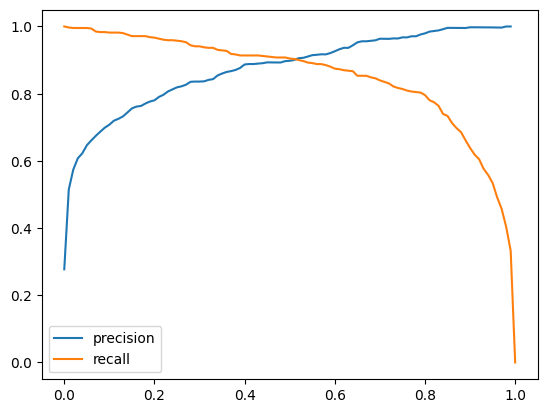

In [17]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

## Question 4

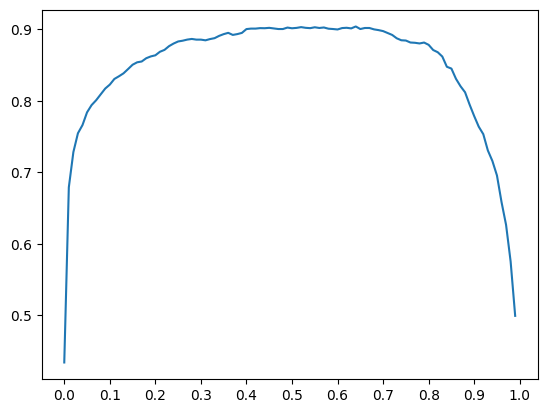

In [18]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

## Question 5

In [23]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(train_val_ds):
    df_train = train_val_ds.iloc[train_idx]
    df_val = train_val_ds.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0)
    model.fit(X_train, y_train)

    dicts = df_val[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [27]:
print(str(round(np.mean(scores),3)) + " +- " + str(round(np.std(scores),3)))

0.978 - 0.005


## Question 6

In [31]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(train_val_ds):
        df_train = train_val_ds.iloc[train_idx]
        df_val = train_val_ds.iloc[val_idx]
    
        y_train = df_train.above_average
        y_val = df_val.above_average
    
        dicts = df_train[features].to_dict(orient='records')
    
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(dicts)
    
        model = LogisticRegression(solver='liblinear', C=C)
        model.fit(X_train, y_train)
    
        dicts = df_val[features].to_dict(orient='records')
    
        X = dv.transform(dicts)
        y_pred = model.predict_proba(X)[:, 1]
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print("C: " + str(C) + ", " + str(round(np.mean(scores),3)) + " +- " + str(round(np.std(scores),3)))

C: 0.01, 0.951 +- 0.006
C: 0.1, 0.97 +- 0.004
C: 1, 0.978 +- 0.005
C: 10, 0.98 +- 0.003
